In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import datetime

import matplotlib.pyplot as plt

from scipy import stats
import math
import random

from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import  mean_squared_log_error

from xgboost import XGBRegressor

In [2]:
#Global Variables for grid search
n_splits = 3
n_jobs = 3

max_depth_min = 3
max_depth_max = 5
n_estimator_min = 100
n_estimator_max = 300

test_size =0.2
random_state = 1986

In [3]:
train_File = 'train.csv'
test_File = 'test.csv'

df_train = pd.read_csv(train_File)
df_test = pd.read_csv(test_File)
df_test['SalePrice'] = 0
df_concat = pd.concat([df_train,df_test])

In [4]:
def giveMeWrangledData(df, testFile=False, log=False):
    
    
    df = df.drop(['Id', 'GarageYrBlt','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'],axis=1)
    
    df['LotFrontage'] =df.LotFrontage.fillna(df.LotFrontage.mode()[0])
    df['MasVnrArea']=df.MasVnrArea.fillna(0.0)
    df['TotalBsmtSF'] = df.TotalBsmtSF.fillna(0)
    df['BsmtFullBath'] = df.BsmtFullBath.fillna(0)
    df['BsmtHalfBath'] = df.BsmtHalfBath.fillna(0)
    df['GarageCars'] = df.GarageCars.fillna(0)
    df['GarageArea'] = df.GarageArea.fillna(0)
    
    #convert data type
    #we are being little lineant to give int64 for YearBuilt, YrSold but those guys are going to be box-coxed 
    #so let them at least enjoy the bigger size for now
    int64_variables = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', \
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', \
                     'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',\
                     'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                     'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']
    
    #if testFile:
    #    int64_variables.remove('SalePrice')

        
        
        
    
    for c in int64_variables:
        if log:
            print("Changing the data type for :", c)
        #df[c] = df[c].astype(np.int64)
        df[c] = df[c].astype(np.float64)
        
    int_to_categorical_variables = ['MSSubClass', 'OverallQual', 'OverallCond', 'FireplaceQu', 'MoSold']
    for c in int_to_categorical_variables:
        df[c] = df[c].astype(str)
        
    df = df.fillna('NotAvailable')
    return df
df = giveMeWrangledData(df_concat)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450.0,Pave,NotAvailable,Reg,Lvl,AllPub,Inside,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,2,2008.0,WD,Normal,208500.0
1,20,RL,80.0,9600.0,Pave,NotAvailable,Reg,Lvl,AllPub,FR2,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,5,2007.0,WD,Normal,181500.0
2,60,RL,68.0,11250.0,Pave,NotAvailable,IR1,Lvl,AllPub,Inside,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,9,2008.0,WD,Normal,223500.0
3,70,RL,60.0,9550.0,Pave,NotAvailable,IR1,Lvl,AllPub,Corner,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,2,2006.0,WD,Abnorml,140000.0
4,60,RL,84.0,14260.0,Pave,NotAvailable,IR1,Lvl,AllPub,FR2,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,12,2008.0,WD,Normal,250000.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 76 columns):
MSSubClass       2919 non-null object
MSZoning         2919 non-null object
LotFrontage      2919 non-null float64
LotArea          2919 non-null float64
Street           2919 non-null object
Alley            2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null object
OverallCond      2919 non-null object
YearBuilt        2919 non-null float64
YearRemodAdd     2919 non-null float64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2919 non-null object
Exterior2nd    

In [6]:
def preProcessData(df, log=False):
    
    print("Shape of the data set before pre processing : ", df.shape )

    #get dummies
    if log:
        print("Categorical columns : ", list(df.select_dtypes(exclude=np.number)))
    df = pd.get_dummies(df, dtype=np.float64)
    
    print("\n\nShape of the data set after pre processing : ", df.shape )
    
    if log:
        print("Columns in the data set are : ",list(df))

    return df

df_prep = preProcessData(df)
df_prep.info()

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 351 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(351)
memory usage: 7.8 MB


https://stats.stackexchange.com/questions/130262/why-not-log-transform-all-variables-that-are-not-of-main-interest

In [7]:
def newBoxCoxTranformation(df,target,testFile=False, log=False):
    
    #assuming that only numerical features are presented
    print("Shape of the dataset initial : ", df.shape)
    
    if not testFile:
        df =df[df.SalePrice >0]
        print("Shape of the dataset before transformation : ", df.shape)
        y = np.array(df[target].apply( lambda x: math.log(x)))
        X= df.drop(target,axis = 1)
        x_columns = list(X)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        X = pd.DataFrame(X, columns=x_columns)
        
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]

        X = X.values
        print("Shape of the dataset after transformation : ", X.shape, y.shape)
        return X,y
    else:
        df = df[df.SalePrice == 0.0]
        print("Shape of the dataset before transformation : ", df.shape)
        X=df.drop(target,axis = 1)
        x_columns = list(X)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        
        X = pd.DataFrame(X, columns=x_columns)
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]
        
        
        #X = preprocessing.power_transform( X, method='box-cox')
        X = X.values
        print("Shape of the dataset after transformation : ", X.shape)
        return X
        
    

X = newBoxCoxTranformation(df_prep,'SalePrice',True,False)  
X,y = newBoxCoxTranformation(df_prep,'SalePrice',False,False)

Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350) (1460,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=random.randint(1,500))#, stratify=df.BldgType)

In [9]:
reg = XGBRegressor()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

0.8613083244907593

In [10]:
np.sqrt(mean_squared_log_error(y_test, reg.predict(X_test)))

0.0121327062488616

In [11]:
reg.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

##### We need to have different pre-processing logic to test data. We will come back to it little later.

In [13]:
def checkTheTestFile(reg):
    df_test = pd.read_csv(test_File)
    df_test['SalePrice'] = 0.0
    
    df_train =  pd.read_csv(train_File)
    df_concat = pd.concat([df_train,df_test])

    #print(df_test[df_test.TotalBsmtSF.isna()])
    #return
    df = giveMeWrangledData(df_concat,True)
    
    #print(df.info())
    df = preProcessData(df)
    #print(df.info())
    X = newBoxCoxTranformation(df,'SalePrice',True)
    #print(np.sqrt(mean_squared_log_error(y, reg.predict(X))))
    
    df_test['SalePrice'] = np.exp(reg.predict(X))
    
    
    return df_test
df_test = checkTheTestFile(reg)

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)


In [14]:
df_test[['Id','SalePrice']]

,Id,SalePrice
0,1461,125787.546875
1,1462,141982.984375
2,1463,191110.000000
3,1464,200240.312500
4,1465,192861.265625
5,1466,184632.828125
6,1467,169653.500000
7,1468,171752.890625
8,1469,204392.515625
9,1470,138786.703125


In [15]:
df_test[['Id','SalePrice']].to_csv('submission.csv',index=False)

##### I got Kaggle Rank of 2539/4463 with RMSLE =0.14357
##### As on 1/17/2019 : 9:06PM IST
* 0.13501 ==> 2040 
* 0.13252 ==> 1865
* 0.13002 ==> 1704
* 0.12658 ==> 1500
* 0.12351 ==> 1250
* 0.12081 ==> 1000
* 0.11572 ==> 500
* 0.11475 ==> 250
* 0.11310 ==> 100
* 0.10985 ==> 50
* 0.10973 ==> 25
* 0.10845 ==> 10
* 0.08021 ==> 5
* 0.00000 ==> 1

##### Now that I know around what score gets what rank; can we have a function which would what would be testing score ?

##### Logic is to predict first the testing samples. Later use that for training and predict the initial training data set. We would then have actual and predicted SalePrices with which we can calculated the RMSLE.

##### Would this logic work ? let us try for our case now and compare that with Kaggle result....Finger crossed :)

In [16]:
def forCrossValidationStratifiedShuffleSplit(df):
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    print("Number of Splits configured :", sss.get_n_splits(df, df.BldgType))
    
    for train_index, test_index in sss.split(df, df.BldgType):
        yield train_index, test_index
        
    for train_index, test_index in sss.split(df, df.OverallQual):
        yield train_index, test_index

In [17]:
def checkTheTestingScore(df_test, max_depth, n_estimator):
    
    start_time = datetime.datetime.now()
 
    df_train =  pd.read_csv(train_File)
    df_train.SalePrice = 0
    df_concat = pd.concat([df_train,df_test])
    
    X,y = newBoxCoxTranformation(preProcessData((giveMeWrangledData(df_concat))),'SalePrice')
    reg=XGBRegressor(max_depth=max_depth, n_estimator=n_estimator)
    
    #cv = ShuffleSplit(n_splits=3, test_size=random.randint(7,9)/10, random_state=random.randint(1,1000))
    #print(datetime.datetime())
    cross_cv = cross_val_score(reg, X, y,\
                               cv=forCrossValidationStratifiedShuffleSplit(df_test), \
                               scoring='neg_mean_squared_log_error',n_jobs=n_jobs)
    print(" Validat Median Score : ", np.sqrt(np.median(cross_cv) * -1), \
          "Average Score : ", np.sqrt(np.average(cross_cv) * -1) )
    
    reg.fit(X,y)
    training_score = np.sqrt(mean_squared_log_error(y, reg.predict(X)))
    print("Training Score :", training_score)
    
    X = newBoxCoxTranformation(preProcessData((giveMeWrangledData(df_concat))),'SalePrice',True)
    df_train =  pd.read_csv(train_File)
    df_train['predicted_SalePrice']=np.exp(reg.predict(X))
    
    testing_score = np.sqrt(mean_squared_log_error(df_train.SalePrice,df_train.predicted_SalePrice))
    
    print("max_depth :", max_depth, "n_estimator :", n_estimator,"RMSLE : ", testing_score)
    print("Total time for validation to testing score : ", datetime.datetime.now()- start_time)
    
    return [training_score, np.sqrt(np.average(cross_cv) * -1), testing_score]
    
dummy = checkTheTestingScore(df_test,3,100)
print(dummy[0],dummy[1],dummy[2],3,100)

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 3
 Validat Median Score :  0.0037447048547585102 Average Score :  0.0039112259600007976
Training Score : 0.002591130324273707
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 100 RMSLE :  0.16589711298464754
Total time for validation to testing score :  0:00:24.489490
0.002591130324273707 0.0039112259600007976 0.16589711298464754 3 100


##### This is good news; we have the RMSLE calculation matching amost to that of Kaggle.

In [18]:
def doGridSearch():
    
    start_time = datetime.datetime.now()
    
    df_train = pd.read_csv(train_File)
    df_test = pd.read_csv(test_File)
    df_test['SalePrice'] = 0
    df_concat = pd.concat([df_train,df_test])
    
    df = giveMeWrangledData(df_concat)
    df_prep = preProcessData(df)
    
    X,y = newBoxCoxTranformation(df_prep,'SalePrice',False,False)
    
    score_list = []
    for i in range(max_depth_min,max_depth_max):
        for j in range(n_estimator_min,n_estimator_max,100):
            loop_start = datetime.datetime.now()
            
            reg = XGBRegressor(max_depth=i, n_estimators=j)

            #cv = ShuffleSplit(n_splits=3, test_size=random.randint(7,9)/10, random_state=random.randint(1,1000))
            #print(datetime.datetime())
            cross_cv = cross_val_score(reg, X, y,\
                                       cv=forCrossValidationStratifiedShuffleSplit(df_train), \
                                       scoring='neg_mean_squared_log_error',n_jobs=n_jobs)
            print(" Validat Median Score : ", np.sqrt(np.median(cross_cv) * -1), \
                  "Average Score : ", np.sqrt(np.average(cross_cv) * -1) )

            reg.fit(X,y)
            training_score = np.sqrt(mean_squared_log_error(y, reg.predict(X)))
            print("Training Score :", training_score)
            
            scores = checkTheTestingScore(checkTheTestFile(reg),i,j)
            score_list.append((training_score, np.sqrt(np.average(cross_cv) * -1), scores[0],scores[1],scores[2],i,j))
            
            print("Time for max_depth -",i,"n_estimator -",j," is : ", datetime.datetime.now() - loop_start)
    
    print("Total time for GridSearch : ", datetime.datetime.now() - start_time)
    return score_list

score_list = doGridSearch()
sorted(score_list,key= lambda x:x[0])

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350) (1460,)
Number of Splits configured : 3
 Validat Median Score :  0.010652916356030105 Average Score :  0.010584967878131827
Training Score : 0.007038429364622834
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)

[(0.004268714450990581,
  0.010370876344437518,
  0.0026585927751457943,
  0.00482120553614944,
  0.1467279830372148,
  4,
  200),
 (0.005636137999428832,
  0.010096313674068224,
  0.002953958528744047,
  0.004515648857537871,
  0.16361675537052014,
  3,
  200),
 (0.005939174838228012,
  0.010671734234255973,
  0.0022243868867742387,
  0.004197730933198915,
  0.15527371006067386,
  4,
  100),
 (0.007038429364622834,
  0.010584967878131827,
  0.002591130324273707,
  0.0039112259600007976,
  0.16589711298464754,
  3,
  100)]

In [19]:
temp_df = pd.DataFrame(score_list,columns=["training_score",\
                                           "validation_score",\
                                           "predict_training_score",\
                                           "predict_validation_score",\
                                           "testing_score",
                                           "max_depth",
                                           "n_estimator"
                                          ])

temp_df.to_csv("GridSearchResults-"+str(datetime.datetime.now().date()))
temp_df

,training_score,validation_score,predict_training_score,predict_validation_score,testing_score,max_depth,n_estimator
0,0.007038,0.010585,0.002591,0.003911,0.165897,3,100
1,0.005636,0.010096,0.002954,0.004516,0.163617,3,200
2,0.005939,0.010672,0.002224,0.004198,0.155274,4,100
3,0.004269,0.010371,0.002659,0.004821,0.146728,4,200


In [20]:
temp_df[temp_df.testing_score == temp_df.testing_score.min()]

,training_score,validation_score,predict_training_score,predict_validation_score,testing_score,max_depth,n_estimator
3,0.004269,0.010371,0.002659,0.004821,0.146728,4,200


In [21]:
temp_df[temp_df.validation_score == temp_df.validation_score.min()]

,training_score,validation_score,predict_training_score,predict_validation_score,testing_score,max_depth,n_estimator
1,0.005636,0.010096,0.002954,0.004516,0.163617,3,200


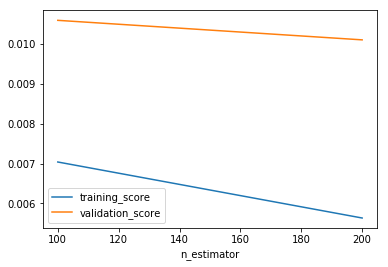

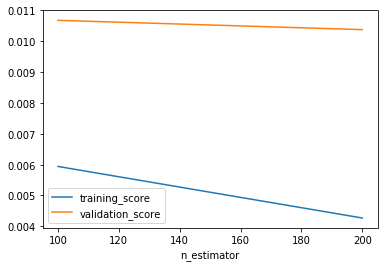

In [22]:
fig, ax = plt.subplots()
ax = temp_df[temp_df.max_depth==3].plot.line('n_estimator','training_score',ax =ax)
ax = temp_df[temp_df.max_depth==3].plot.line('n_estimator','validation_score',ax =ax)
plt.show()
fig, ax = plt.subplots()
ax = temp_df[temp_df.max_depth==4].plot.line('n_estimator','training_score',ax =ax)
ax = temp_df[temp_df.max_depth==4].plot.line('n_estimator','validation_score',ax =ax)
plt.show()
#,'validation_score')

##### Kaggle score remained unchanged, this proves that our logic of test score calculation fails and there must be some value prediction which is huge which brings the average error value up


##### Next Steps:
* re run the grid search and note training score, validation score and testing score. This should not only double check on test score calculation but also gives us the right hyper parameter from the training and validation perspective.
* address the runtime error during scaling or power transform. If boxcox fails attempt a log transformation at least.
* stratify fold testing to check if the training score & validation in the previous exercise still holds goods.
* hyper parameter research for XGBoost
* target variable transformation
* best of best stack approach
* team work stack approach
* XGBoost as the final assesser in best of best stack approach
* XGBoost as the final assesser in the team work starck approach
* 3 layers in stack approach: best of best candidates in the order of their accuracy feeding on input in each case.
* re-assess the dataset

##### The grid search in the kaggle resulted in the different hyper parameter for lowest validation score. Not sure why is that ? validation is through the shuffle split. isnt 3 cross validation set sufficient ?

##### Or it is a game of kfold shuffle split and stratify ?

##### It only makes sense to move on for stacked approach and other hyper parameter tuning if we sort out the cross validation consistency issue. Otherwise, we cannot have the confidence of impact of changes in stacked approaches.

##### Kaggle Grid Search took much more time than the usual; It had to be stopped and the run log for the same is as below:

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350) (1460,)
Number of Splits configured : 50
 Validat Median Score :  0.010605853388661228 Average Score :  0.01063993028476313
Training Score : 0.007038431596732277
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.003963074962939248 Average Score :  0.004025528459227352
Training Score : 0.0025911293893729347
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 100 RMSLE :  0.16589710611857936
Total time for validation to testing score :  0:00:38.395695
Time for max_depth - 3 n_estimator - 100  is :  0:01:16.398827
Number of Splits configured : 50
 Validat Median Score :  0.010164457524950933 Average Score :  0.010263859716439958
Training Score : 0.0056361386228424475
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.0045229537906215965 Average Score :  0.004584721419212606
Training Score : 0.002953957718395085
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 200 RMSLE :  0.16361675376451157
Total time for validation to testing score :  0:00:39.039353
Time for max_depth - 3 n_estimator - 200  is :  0:01:55.121759
Number of Splits configured : 50
 Validat Median Score :  0.010067915933977696 Average Score :  0.010162617951518968
Training Score : 0.004729907610187702
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.004886789919261262 Average Score :  0.004950570127316117
Training Score : 0.0032870135996101485
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 300 RMSLE :  0.15854581404945384
Total time for validation to testing score :  0:00:38.713473
Time for max_depth - 3 n_estimator - 300  is :  0:02:34.467749
Number of Splits configured : 50
 Validat Median Score :  0.010031550727234028 Average Score :  0.010114548385909711
Training Score : 0.004137658964206967
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.005156676532083364 Average Score :  0.005208739779062851
Training Score : 0.003464044402888697
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 400 RMSLE :  0.15891033248782527
Total time for validation to testing score :  0:00:38.377084
Time for max_depth - 3 n_estimator - 400  is :  0:03:09.069098
Number of Splits configured : 50
 Validat Median Score :  0.010003588314764464 Average Score :  0.010095308175260236
Training Score : 0.003612314404594016
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.005301120324932762 Average Score :  0.005359942786008654
Training Score : 0.003575030344455324
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 500 RMSLE :  0.15997912759206634
Total time for validation to testing score :  0:00:38.720677
Time for max_depth - 3 n_estimator - 500  is :  0:03:47.176399
Number of Splits configured : 50
 Validat Median Score :  0.009968275698600898 Average Score :  0.010085755359241718
Training Score : 0.003214559632451576
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.005453521149490259 Average Score :  0.005489480487247361
Training Score : 0.0037099298917688582
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 600 RMSLE :  0.16678947125103266
Total time for validation to testing score :  0:00:38.050646
Time for max_depth - 3 n_estimator - 600  is :  0:04:25.326519
Number of Splits configured : 50
 Validat Median Score :  0.009966896707775856 Average Score :  0.010084387370307271
Training Score : 0.0028983093708892273
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.005537868852061069 Average Score :  0.005580417070560992
Training Score : 0.0037519680466047527
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 700 RMSLE :  0.1624359025109474
Total time for validation to testing score :  0:00:38.240350
Time for max_depth - 3 n_estimator - 700  is :  0:05:03.024459
Number of Splits configured : 50
 Validat Median Score :  0.009974188905411872 Average Score :  0.010084779325504325
Training Score : 0.002619427571739087
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.005645195441630579 Average Score :  0.005667058779515816
Training Score : 0.003778947941939772
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 800 RMSLE :  0.16636904079548867
Total time for validation to testing score :  0:00:39.277031
Time for max_depth - 3 n_estimator - 800  is :  0:05:42.221013
Number of Splits configured : 50
 Validat Median Score :  0.010535750685004472 Average Score :  0.01057521179313502
Training Score : 0.0059391745473512825
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.004299102264058545 Average Score :  0.004382130479906476
Training Score : 0.002224387274423949
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 100 RMSLE :  0.15527370926178566
Total time for validation to testing score :  0:00:47.406490
Time for max_depth - 4 n_estimator - 100  is :  0:01:35.565760
Number of Splits configured : 50
 Validat Median Score :  0.010241480449983766 Average Score :  0.010323579764575116
Training Score : 0.00426871394343577
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.004801310176962207 Average Score :  0.004892535427301638
Training Score : 0.0026585908646482607
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 200 RMSLE :  0.14672798264711417
Total time for validation to testing score :  0:00:47.444289
Time for max_depth - 4 n_estimator - 200  is :  0:02:23.794761
Number of Splits configured : 50
 Validat Median Score :  0.010215651186709983 Average Score :  0.010268801183493291
Training Score : 0.0033050740969666897
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.005109671115628138 Average Score :  0.005148193892790108
Training Score : 0.002798516727774696
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 300 RMSLE :  0.14960519580929818
Total time for validation to testing score :  0:00:47.523822
Time for max_depth - 4 n_estimator - 300  is :  0:03:11.799130
Number of Splits configured : 50
 Validat Median Score :  0.01019995781155399 Average Score :  0.010248392682759538
Training Score : 0.0026575146034257297
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.005243305377027735 Average Score :  0.005309945761140287
Training Score : 0.0028986209252044736
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 400 RMSLE :  0.15048094864418257
Total time for validation to testing score :  0:00:47.643094
Time for max_depth - 4 n_estimator - 400  is :  0:04:00.776402
Number of Splits configured : 50
 Validat Median Score :  0.010203940981587384 Average Score :  0.010242938647312383
Training Score : 0.0021421201886005327
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.0053465418090232995 Average Score :  0.005401667383148008
Training Score : 0.0029753636578897734
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 500 RMSLE :  0.14971132166419993
Total time for validation to testing score :  0:00:47.951644
Time for max_depth - 4 n_estimator - 500  is :  0:04:49.872304
Number of Splits configured : 50
 Validat Median Score :  0.010211123191725763 Average Score :  0.010242256244842627
Training Score : 0.0017628090836397205
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.00548012145618102 Average Score :  0.00549639953434934
Training Score : 0.0030275654013389415
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 600 RMSLE :  0.15078729828998982
Total time for validation to testing score :  0:00:47.821086
Time for max_depth - 4 n_estimator - 600  is :  0:05:39.280246
Number of Splits configured : 50
 Validat Median Score :  0.010215688374317893 Average Score :  0.01024706384852549
Training Score : 0.0015177409116944552
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.005535583675724044 Average Score :  0.005553292355690933
Training Score : 0.0030833371071368864
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 700 RMSLE :  0.1526358089566089
Total time for validation to testing score :  0:00:47.117791
Time for max_depth - 4 n_estimator - 700  is :  0:06:26.397247
Number of Splits configured : 50
 Validat Median Score :  0.010218665352288988 Average Score :  0.01025157562569287
Training Score : 0.0012771673814162422
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.0055164472736577725 Average Score :  0.005564443457761828
Training Score : 0.0031095779903570916
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 800 RMSLE :  0.1550713296860458
Total time for validation to testing score :  0:00:47.615125
Time for max_depth - 4 n_estimator - 800  is :  0:07:18.506528
Number of Splits configured : 50
 Validat Median Score :  0.010471928861828305 Average Score :  0.010560800636302914
Training Score : 0.004870750411988053
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.004585560853133293 Average Score :  0.004678943155454422
Training Score : 0.0018536104557018364
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 100 RMSLE :  0.15132102524732266
Total time for validation to testing score :  0:00:57.532332
Time for max_depth - 5 n_estimator - 100  is :  0:01:55.140243
Number of Splits configured : 50
 Validat Median Score :  0.010340789755912612 Average Score :  0.010400747422270972
Training Score : 0.0030612672725076604
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.004971892959919152 Average Score :  0.0050900177663088355
Training Score : 0.0020996578208212907
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 200 RMSLE :  0.1526653129828918
Total time for validation to testing score :  0:00:57.576736
Time for max_depth - 5 n_estimator - 200  is :  0:02:55.534069
Number of Splits configured : 50
 Validat Median Score :  0.0103395471525789 Average Score :  0.010377445558102338
Training Score : 0.0021363983405856307
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 50
 Validat Median Score :  0.005133136943321411 Average Score :  0.005217788972193297
Training Score : 0.002182295997122291
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 300 RMSLE :  0.1518783947651675
Total time for validation to testing score :  0:00:57.820972
Time for max_depth - 5 n_estimator - 300  is :  0:03:54.787348
Number of Splits configured : 50

##### The full grid search for split count = 10 is as below. It is evident that 
* testing training score is of no use. We can ignore it in the future grid searches. it would save couple minutes from one grid search.

##### Following are the observation yet to be confirmed:
* Does the testing score confidence is high; post custom stratified split ? We will have predict with the best testing score and see the rank in Kaggle. 6,800 = > 0.15404  & 3,800 ==> 0.16021
* Does we have relation between validation score and testing score ?
* Can we first focus on training score to be 0 with other hyper parameters ? would that be overfitting ? Should we need still learning curve of validation vs testing score.?
* Can we ignore n_estimator and see if the validation score converges with testing score only with max_depth and other hyper parameters?

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350) (1460,)
Number of Splits configured : 10
 Validat Median Score :  0.010660628816858473 Average Score :  0.010712291170971206
Training Score : 0.007038431596732277
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0038685014870937016 Average Score :  0.003945944135643825
Training Score : 0.0025911293893729347
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 100 RMSLE :  0.16589710611857936
Total time for validation to testing score :  0:00:10.595768
Time for max_depth - 3 n_estimator - 100  is :  0:00:20.951109
Number of Splits configured : 10
 Validat Median Score :  0.010220111615261993 Average Score :  0.010247694871595454
Training Score : 0.0056361386228424475
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.004427412372818853 Average Score :  0.004519207617073843
Training Score : 0.002953957718395085
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 200 RMSLE :  0.16361675376451157
Total time for validation to testing score :  0:00:10.771925
Time for max_depth - 3 n_estimator - 200  is :  0:00:31.162498
Number of Splits configured : 10
 Validat Median Score :  0.010119503711309765 Average Score :  0.010134513915838141
Training Score : 0.004729907610187702
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.004740102465750728 Average Score :  0.0048481190076194725
Training Score : 0.0032870135996101485
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 300 RMSLE :  0.15854581404945384
Total time for validation to testing score :  0:00:11.043171
Time for max_depth - 3 n_estimator - 300  is :  0:00:41.603657
Number of Splits configured : 10
 Validat Median Score :  0.010052206108711376 Average Score :  0.010081495829923277
Training Score : 0.004137658964206967
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005092133985564617 Average Score :  0.005162397432148826
Training Score : 0.003464044402888697
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 400 RMSLE :  0.15891033248782527
Total time for validation to testing score :  0:00:10.827631
Time for max_depth - 3 n_estimator - 400  is :  0:00:52.009756
Number of Splits configured : 10
 Validat Median Score :  0.01005572713986907 Average Score :  0.010058631282817714
Training Score : 0.003612314404594016
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005169288368884105 Average Score :  0.005295331862863106
Training Score : 0.003575030344455324
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 500 RMSLE :  0.15997912759206634
Total time for validation to testing score :  0:00:10.644307
Time for max_depth - 3 n_estimator - 500  is :  0:01:01.404919
Number of Splits configured : 10
 Validat Median Score :  0.01007141438500132 Average Score :  0.01004577847319359
Training Score : 0.003214559632451576
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0052968138663305854 Average Score :  0.005433371562782959
Training Score : 0.0037099298917688582
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 600 RMSLE :  0.16678947125103266
Total time for validation to testing score :  0:00:10.781986
Time for max_depth - 3 n_estimator - 600  is :  0:01:11.744583
Number of Splits configured : 10
 Validat Median Score :  0.010058153989662005 Average Score :  0.010037524245889388
Training Score : 0.0028983093708892273
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005386338674505355 Average Score :  0.005568449647823775
Training Score : 0.0037519680466047527
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 700 RMSLE :  0.1624359025109474
Total time for validation to testing score :  0:00:11.296820
Time for max_depth - 3 n_estimator - 700  is :  0:01:25.423751
Number of Splits configured : 10
 Validat Median Score :  0.010081727770399982 Average Score :  0.01003466838734482
Training Score : 0.002619427571739087
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.00547278563323019 Average Score :  0.005599716581924151
Training Score : 0.003778947941939772
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 800 RMSLE :  0.16636904079548867
Total time for validation to testing score :  0:00:11.495594
Time for max_depth - 3 n_estimator - 800  is :  0:01:36.634810
Number of Splits configured : 10
 Validat Median Score :  0.010666590091852897 Average Score :  0.010656473000999521
Training Score : 0.0059391745473512825
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.004185389756556545 Average Score :  0.004327771867761287
Training Score : 0.002224387274423949
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 100 RMSLE :  0.15527370926178566
Total time for validation to testing score :  0:00:13.378799
Time for max_depth - 4 n_estimator - 100  is :  0:00:26.606558
Number of Splits configured : 10
 Validat Median Score :  0.010288561442837926 Average Score :  0.010353665740335775
Training Score : 0.00426871394343577
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.004750793809916591 Average Score :  0.004850935216607905
Training Score : 0.0026585908646482607
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 200 RMSLE :  0.14672798264711417
Total time for validation to testing score :  0:00:13.323291
Time for max_depth - 4 n_estimator - 200  is :  0:00:39.421012
Number of Splits configured : 10
 Validat Median Score :  0.010260322112434443 Average Score :  0.010302408805337691
Training Score : 0.0033050740969666897
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005089715107436814 Average Score :  0.005093262176181698
Training Score : 0.002798516727774696
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 300 RMSLE :  0.14960519580929818
Total time for validation to testing score :  0:00:13.563458
Time for max_depth - 4 n_estimator - 300  is :  0:00:54.134910
Number of Splits configured : 10
 Validat Median Score :  0.0102578537542367 Average Score :  0.010273038212529591
Training Score : 0.0026575146034257297
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005136890329462546 Average Score :  0.005254884462945024
Training Score : 0.0028986209252044736
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 400 RMSLE :  0.15048094864418257
Total time for validation to testing score :  0:00:13.363792
Time for max_depth - 4 n_estimator - 400  is :  0:01:06.283182
Number of Splits configured : 10
 Validat Median Score :  0.010248993386452486 Average Score :  0.010258904768204393
Training Score : 0.0021421201886005327
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005296016256457994 Average Score :  0.005359513913293785
Training Score : 0.0029753636578897734
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 500 RMSLE :  0.14971132166419993
Total time for validation to testing score :  0:00:13.247953
Time for max_depth - 4 n_estimator - 500  is :  0:01:19.253289
Number of Splits configured : 10
 Validat Median Score :  0.010228118782626836 Average Score :  0.010255659327933823
Training Score : 0.0017628090836397205
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005348601182699322 Average Score :  0.0054060652546306775
Training Score : 0.0030275654013389415
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 600 RMSLE :  0.15078729828998982
Total time for validation to testing score :  0:00:13.622298
Time for max_depth - 4 n_estimator - 600  is :  0:01:34.571429
Number of Splits configured : 10
 Validat Median Score :  0.010235739385747507 Average Score :  0.01025671554037758
Training Score : 0.0015177409116944552
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005470976209190835 Average Score :  0.005481205011350714
Training Score : 0.0030833371071368864
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 700 RMSLE :  0.1526358089566089
Total time for validation to testing score :  0:00:13.313368
Time for max_depth - 4 n_estimator - 700  is :  0:01:48.682569
Number of Splits configured : 10
 Validat Median Score :  0.010237064028971444 Average Score :  0.010258292794228671
Training Score : 0.0012771673814162422
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005466595011987888 Average Score :  0.005505827274609353
Training Score : 0.0031095779903570916
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 800 RMSLE :  0.1550713296860458
Total time for validation to testing score :  0:00:13.402412
Time for max_depth - 4 n_estimator - 800  is :  0:01:59.283457
Number of Splits configured : 10
 Validat Median Score :  0.010623645898302957 Average Score :  0.010612053762591982
Training Score : 0.004870750411988053
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.004565775168035773 Average Score :  0.0046351315077797
Training Score : 0.0018536104557018364
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 100 RMSLE :  0.15132102524732266
Total time for validation to testing score :  0:00:16.176222
Time for max_depth - 5 n_estimator - 100  is :  0:00:32.117689
Number of Splits configured : 10
 Validat Median Score :  0.010443658677993744 Average Score :  0.01043627218961481
Training Score : 0.0030612672725076604
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005030829715968213 Average Score :  0.005098559349896692
Training Score : 0.0020996578208212907
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 200 RMSLE :  0.1526653129828918
Total time for validation to testing score :  0:00:15.746076
Time for max_depth - 5 n_estimator - 200  is :  0:00:48.228114
Number of Splits configured : 10
 Validat Median Score :  0.010431284890970154 Average Score :  0.010411516847186959
Training Score : 0.0021363983405856307
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0051726871437104555 Average Score :  0.005211810072519971
Training Score : 0.002182295997122291
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 300 RMSLE :  0.1518783947651675
Total time for validation to testing score :  0:00:16.012567
Time for max_depth - 5 n_estimator - 300  is :  0:01:04.524685
Number of Splits configured : 10
 Validat Median Score :  0.010438481390615172 Average Score :  0.010409631316592187
Training Score : 0.0015992707127822341
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005177896995311865 Average Score :  0.0052336344143611956
Training Score : 0.0021612134639806156
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 400 RMSLE :  0.1473510814314955
Total time for validation to testing score :  0:00:15.994628
Time for max_depth - 5 n_estimator - 400  is :  0:01:20.327345
Number of Splits configured : 10
 Validat Median Score :  0.010446381008839883 Average Score :  0.01041285497006029
Training Score : 0.0011458980688721471
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0052764408595980415 Average Score :  0.0052973422513788995
Training Score : 0.002296148616968521
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 500 RMSLE :  0.15306469777949425
Total time for validation to testing score :  0:00:15.674474
Time for max_depth - 5 n_estimator - 500  is :  0:01:36.989000
Number of Splits configured : 10
 Validat Median Score :  0.01045188948468622 Average Score :  0.010413532850752522
Training Score : 0.0008434622357684127
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005353809811312039 Average Score :  0.005356419708744355
Training Score : 0.0023245313230883594
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 600 RMSLE :  0.1507119243713346
Total time for validation to testing score :  0:00:16.176705
Time for max_depth - 5 n_estimator - 600  is :  0:01:54.104671
Number of Splits configured : 10
 Validat Median Score :  0.010455689059833722 Average Score :  0.0104144655676667
Training Score : 0.0006007572331870948
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005325385138549469 Average Score :  0.005288078951061614
Training Score : 0.0023570750749820745
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 700 RMSLE :  0.15230909878959098
Total time for validation to testing score :  0:00:15.479139
Time for max_depth - 5 n_estimator - 700  is :  0:02:08.361935
Number of Splits configured : 10
 Validat Median Score :  0.010460758707985027 Average Score :  0.010418192602792784
Training Score : 0.0004438403395231779
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005332892740245079 Average Score :  0.005389195280552788
Training Score : 0.002381321021574892
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 5 n_estimator : 800 RMSLE :  0.15477810315140575
Total time for validation to testing score :  0:00:15.742027
Time for max_depth - 5 n_estimator - 800  is :  0:02:24.840407
Number of Splits configured : 10
 Validat Median Score :  0.010628933327359546 Average Score :  0.010647530636771763
Training Score : 0.003995398595216605
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005025659439723696 Average Score :  0.005055128874905765
Training Score : 0.0016687909270228006
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 6 n_estimator : 100 RMSLE :  0.1525472923481863
Total time for validation to testing score :  0:00:18.296819
Time for max_depth - 6 n_estimator - 100  is :  0:00:36.296336
Number of Splits configured : 10
 Validat Median Score :  0.010518982483795838 Average Score :  0.01053873776522127
Training Score : 0.002156772855165171
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0052093258412318835 Average Score :  0.005175250856052308
Training Score : 0.0017340243431334893
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 6 n_estimator : 200 RMSLE :  0.15109485747673176
Total time for validation to testing score :  0:00:18.132463
Time for max_depth - 6 n_estimator - 200  is :  0:00:55.011197
Number of Splits configured : 10
 Validat Median Score :  0.010503461141855987 Average Score :  0.010540068139804154
Training Score : 0.0013096950780381899
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005338119554872232 Average Score :  0.005380517410410699
Training Score : 0.0017933444519191374
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 6 n_estimator : 300 RMSLE :  0.14759104824463293
Total time for validation to testing score :  0:00:18.144462
Time for max_depth - 6 n_estimator - 300  is :  0:01:14.435582
Number of Splits configured : 10
 Validat Median Score :  0.010501222728797633 Average Score :  0.010544739112585941
Training Score : 0.0008318112086056907
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0053364580248857615 Average Score :  0.005366321965942329
Training Score : 0.0018454425291068942
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 6 n_estimator : 400 RMSLE :  0.1468716861136306
Total time for validation to testing score :  0:00:18.403272
Time for max_depth - 6 n_estimator - 400  is :  0:01:33.918916
Number of Splits configured : 10
 Validat Median Score :  0.01050556112029886 Average Score :  0.010544110036021136
Training Score : 0.0005547885426813175
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005418069999113378 Average Score :  0.0053459794266142455
Training Score : 0.001860385184542899
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 6 n_estimator : 500 RMSLE :  0.14728160504288246
Total time for validation to testing score :  0:00:17.755007
Time for max_depth - 6 n_estimator - 500  is :  0:01:51.000731
Number of Splits configured : 10
 Validat Median Score :  0.010505204557386273 Average Score :  0.010544297530596011
Training Score : 0.00036101443861175374
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0053961734146259245 Average Score :  0.005420288723986371
Training Score : 0.001963671248188517
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 6 n_estimator : 600 RMSLE :  0.14632439671618344
Total time for validation to testing score :  0:00:17.985782
Time for max_depth - 6 n_estimator - 600  is :  0:02:09.990591
Number of Splits configured : 10
 Validat Median Score :  0.010505183379354495 Average Score :  0.010543981557812061
Training Score : 0.0002134108309947307
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005480023345492569 Average Score :  0.0054422387642439445
Training Score : 0.0019136682678855363
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 6 n_estimator : 700 RMSLE :  0.15164297027873225
Total time for validation to testing score :  0:00:18.916964
Time for max_depth - 6 n_estimator - 700  is :  0:02:28.647240
Number of Splits configured : 10
 Validat Median Score :  0.010505183379354495 Average Score :  0.010543892843887947
Training Score : 0.00013464801020198692
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0054008357582985105 Average Score :  0.005400587179095282
Training Score : 0.0018460245077011423
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 6 n_estimator : 800 RMSLE :  0.1454500325621521
Total time for validation to testing score :  0:00:18.443938
Time for max_depth - 6 n_estimator - 800  is :  0:02:38.156488
Number of Splits configured : 10
 Validat Median Score :  0.010621189355931418 Average Score :  0.010620344849261968
Training Score : 0.003391671709632651
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.004993777137430526 Average Score :  0.004981373460466849
Training Score : 0.0012655407323767
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 7 n_estimator : 100 RMSLE :  0.1606220546044518
Total time for validation to testing score :  0:00:20.749402
Time for max_depth - 7 n_estimator - 100  is :  0:00:41.728671
Number of Splits configured : 10
 Validat Median Score :  0.010580471882671508 Average Score :  0.010534575614241327
Training Score : 0.001637593140052451
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005225672642569826 Average Score :  0.005203868669261934
Training Score : 0.0013709968546754597
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 7 n_estimator : 200 RMSLE :  0.15967243677452092
Total time for validation to testing score :  0:00:20.523424
Time for max_depth - 7 n_estimator - 200  is :  0:01:04.848132
Number of Splits configured : 10
 Validat Median Score :  0.010597891670128572 Average Score :  0.010529766916011034
Training Score : 0.000826421018231957
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005052356924188602 Average Score :  0.005224753047991301
Training Score : 0.0013536404081975154
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 7 n_estimator : 300 RMSLE :  0.1579130205824377
Total time for validation to testing score :  0:00:20.558794
Time for max_depth - 7 n_estimator - 300  is :  0:01:25.664143
Number of Splits configured : 10
 Validat Median Score :  0.010606741015893727 Average Score :  0.010530507722406561
Training Score : 0.0004125318299446503
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005084620449810051 Average Score :  0.005249388739534285
Training Score : 0.0013567932916912974
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 7 n_estimator : 400 RMSLE :  0.16344474216728364
Total time for validation to testing score :  0:00:20.699449
Time for max_depth - 7 n_estimator - 400  is :  0:01:48.279488
Number of Splits configured : 10
 Validat Median Score :  0.010615042617051214 Average Score :  0.010530716491755646
Training Score : 0.0002131195653452131
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005106735823842248 Average Score :  0.005294947114903061
Training Score : 0.00134839218758343
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 7 n_estimator : 500 RMSLE :  0.16291146016449848
Total time for validation to testing score :  0:00:20.389401
Time for max_depth - 7 n_estimator - 500  is :  0:02:10.527248
Number of Splits configured : 10
 Validat Median Score :  0.010615618957064208 Average Score :  0.010530852546169575
Training Score : 0.00012267789324897898
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005164337272216918 Average Score :  0.005290373104529279
Training Score : 0.0013757183786090104
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 7 n_estimator : 600 RMSLE :  0.15916055814840085
Total time for validation to testing score :  0:00:20.409606
Time for max_depth - 7 n_estimator - 600  is :  0:02:17.067572
Number of Splits configured : 10
 Validat Median Score :  0.010615618957064208 Average Score :  0.010530852546169575
Training Score : 0.00012267789324897898
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005164337272216918 Average Score :  0.005290373104529279
Training Score : 0.0013757183786090104
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 7 n_estimator : 700 RMSLE :  0.15916055814840085
Total time for validation to testing score :  0:00:20.886315
Time for max_depth - 7 n_estimator - 700  is :  0:02:20.729472
Number of Splits configured : 10
 Validat Median Score :  0.010615618957064208 Average Score :  0.010530852546169575
Training Score : 0.00012267789324897898
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005164337272216918 Average Score :  0.005290373104529279
Training Score : 0.0013757183786090104
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 7 n_estimator : 800 RMSLE :  0.15916055814840085
Total time for validation to testing score :  0:00:21.088693
Time for max_depth - 7 n_estimator - 800  is :  0:02:25.764752
Number of Splits configured : 10
 Validat Median Score :  0.01069995439307379 Average Score :  0.010678249996567492
Training Score : 0.0027007791842996857
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005204627481687778 Average Score :  0.0052342247506849265
Training Score : 0.0009228725919254304
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 8 n_estimator : 100 RMSLE :  0.16520089214109476
Total time for validation to testing score :  0:00:23.119938
Time for max_depth - 8 n_estimator - 100  is :  0:00:46.340952
Number of Splits configured : 10
 Validat Median Score :  0.010591413342594636 Average Score :  0.010616016219716584
Training Score : 0.0009772613552508007
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.00531454988459694 Average Score :  0.005403927689198952
Training Score : 0.0010714365549986365
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 8 n_estimator : 200 RMSLE :  0.15654514726762872
Total time for validation to testing score :  0:00:22.982755
Time for max_depth - 8 n_estimator - 200  is :  0:01:11.977795
Number of Splits configured : 10
 Validat Median Score :  0.010581782889079757 Average Score :  0.010615088818746047
Training Score : 0.0004007661702658827
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005360907549517269 Average Score :  0.005472558085553763
Training Score : 0.001073116317915484
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 8 n_estimator : 300 RMSLE :  0.15686657705672694
Total time for validation to testing score :  0:00:23.280209
Time for max_depth - 8 n_estimator - 300  is :  0:01:38.285135
Number of Splits configured : 10
 Validat Median Score :  0.010577603031373624 Average Score :  0.010615168894751462
Training Score : 0.0001586635357806597
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005323160390424203 Average Score :  0.005440473376568874
Training Score : 0.0010246284870418295
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 8 n_estimator : 400 RMSLE :  0.16842647810423278
Total time for validation to testing score :  0:00:23.090137
Time for max_depth - 8 n_estimator - 400  is :  0:01:57.548003
Number of Splits configured : 10
 Validat Median Score :  0.010577603031373624 Average Score :  0.010615176734032745
Training Score : 0.00010994404394778538
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005471388971868299 Average Score :  0.005487464963757937
Training Score : 0.0010075338696442957
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 8 n_estimator : 500 RMSLE :  0.16894069768238226
Total time for validation to testing score :  0:00:22.957093
Time for max_depth - 8 n_estimator - 500  is :  0:02:02.164753
Number of Splits configured : 10
 Validat Median Score :  0.010577603031373624 Average Score :  0.010615176734032745
Training Score : 0.00010994404394778538
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005471388971868299 Average Score :  0.005487464963757937
Training Score : 0.0010075338696442957
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 8 n_estimator : 600 RMSLE :  0.16894069768238226
Total time for validation to testing score :  0:00:23.123677
Time for max_depth - 8 n_estimator - 600  is :  0:02:09.064494
Number of Splits configured : 10
 Validat Median Score :  0.010577603031373624 Average Score :  0.010615176734032745
Training Score : 0.00010994404394778538
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005471388971868299 Average Score :  0.005487464963757937
Training Score : 0.0010075338696442957
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 8 n_estimator : 700 RMSLE :  0.16894069768238226
Total time for validation to testing score :  0:00:22.810783
Time for max_depth - 8 n_estimator - 700  is :  0:02:12.344824
Number of Splits configured : 10
 Validat Median Score :  0.010577603031373624 Average Score :  0.010615176734032745
Training Score : 0.00010994404394778538
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005471388971868299 Average Score :  0.005487464963757937
Training Score : 0.0010075338696442957
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 8 n_estimator : 800 RMSLE :  0.16894069768238226
Total time for validation to testing score :  0:00:23.172399
Time for max_depth - 8 n_estimator - 800  is :  0:02:17.292022
Number of Splits configured : 10
 Validat Median Score :  0.010773730528840187 Average Score :  0.010686873695143621
Training Score : 0.002031902637989683
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005205084951899445 Average Score :  0.005200534129072942
Training Score : 0.0007750246631888383
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 9 n_estimator : 100 RMSLE :  0.17159819414109467
Total time for validation to testing score :  0:00:25.692159
Time for max_depth - 9 n_estimator - 100  is :  0:00:51.853072
Number of Splits configured : 10
 Validat Median Score :  0.010748026493976286 Average Score :  0.010635671902220988
Training Score : 0.0004683357862542922
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005244122224744883 Average Score :  0.005253721453447986
Training Score : 0.0008035961153667416
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 9 n_estimator : 200 RMSLE :  0.16974989122949127
Total time for validation to testing score :  0:00:25.794911
Time for max_depth - 9 n_estimator - 200  is :  0:01:21.326099
Number of Splits configured : 10
 Validat Median Score :  0.010754969285119004 Average Score :  0.01063563451067062
Training Score : 0.00014689878215314378
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005216669974515583 Average Score :  0.005213555801915096
Training Score : 0.0008290415269034545
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 9 n_estimator : 300 RMSLE :  0.16896325545101526
Total time for validation to testing score :  0:00:26.086285
Time for max_depth - 9 n_estimator - 300  is :  0:01:51.097705
Number of Splits configured : 10
 Validat Median Score :  0.010754781832555715 Average Score :  0.010635748275553787
Training Score : 0.00010501060502443066
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0051370133164217145 Average Score :  0.00518515533812861
Training Score : 0.0008033899291239401
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 9 n_estimator : 400 RMSLE :  0.17168487948664338
Total time for validation to testing score :  0:00:25.539314
Time for max_depth - 9 n_estimator - 400  is :  0:01:55.695467
Number of Splits configured : 10
 Validat Median Score :  0.010754781832555715 Average Score :  0.010635748275553787
Training Score : 0.00010501060502443066
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0051370133164217145 Average Score :  0.00518515533812861
Training Score : 0.0008033899291239401
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 9 n_estimator : 500 RMSLE :  0.17168487948664338
Total time for validation to testing score :  0:00:25.289840
Time for max_depth - 9 n_estimator - 500  is :  0:01:59.292943
Number of Splits configured : 10
 Validat Median Score :  0.010754781832555715 Average Score :  0.010635748275553787
Training Score : 0.00010501060502443066
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0051370133164217145 Average Score :  0.00518515533812861
Training Score : 0.0008033899291239401
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 9 n_estimator : 600 RMSLE :  0.17168487948664338
Total time for validation to testing score :  0:00:25.487368
Time for max_depth - 9 n_estimator - 600  is :  0:02:04.145690
Number of Splits configured : 10
 Validat Median Score :  0.010754781832555715 Average Score :  0.010635748275553787
Training Score : 0.00010501060502443066
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0051370133164217145 Average Score :  0.00518515533812861
Training Score : 0.0008033899291239401
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 9 n_estimator : 700 RMSLE :  0.17168487948664338
Total time for validation to testing score :  0:00:25.367989
Time for max_depth - 9 n_estimator - 700  is :  0:02:07.473344
Number of Splits configured : 10
 Validat Median Score :  0.010754781832555715 Average Score :  0.010635748275553787
Training Score : 0.00010501060502443066
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.0051370133164217145 Average Score :  0.00518515533812861
Training Score : 0.0008033899291239401
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 9 n_estimator : 800 RMSLE :  0.17168487948664338
Total time for validation to testing score :  0:00:26.282034
Time for max_depth - 9 n_estimator - 800  is :  0:02:14.369120
Number of Splits configured : 10
 Validat Median Score :  0.010822076767005655 Average Score :  0.010716978153422409
Training Score : 0.0017263123270283762
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.00530270957381721 Average Score :  0.005274452590735041
Training Score : 0.0006178352896532172
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 10 n_estimator : 100 RMSLE :  0.16833274723047736
Total time for validation to testing score :  0:00:28.314587
Time for max_depth - 10 n_estimator - 100  is :  0:00:57.427144
Number of Splits configured : 10
 Validat Median Score :  0.01078878303807479 Average Score :  0.010686911018116614
Training Score : 0.0003291247476366605
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005287710349033135 Average Score :  0.005307228035193094
Training Score : 0.0006458434968873398
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 10 n_estimator : 200 RMSLE :  0.16672121973845191
Total time for validation to testing score :  0:00:27.814048
Time for max_depth - 10 n_estimator - 200  is :  0:01:28.648496
Number of Splits configured : 10
 Validat Median Score :  0.010786990203209789 Average Score :  0.010687019209972011
Training Score : 9.233857712656679e-05
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005297349331981394 Average Score :  0.005307196063998091
Training Score : 0.0006721188545335939
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 10 n_estimator : 300 RMSLE :  0.1699548203603305
Total time for validation to testing score :  0:00:28.263967
Time for max_depth - 10 n_estimator - 300  is :  0:01:48.729475
Number of Splits configured : 10
 Validat Median Score :  0.010786990203209789 Average Score :  0.010687019209972011
Training Score : 9.233857712656679e-05
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005297349331981394 Average Score :  0.005307196063998091
Training Score : 0.0006721188545335939
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 10 n_estimator : 400 RMSLE :  0.1699548203603305
Total time for validation to testing score :  0:00:28.912084
Time for max_depth - 10 n_estimator - 400  is :  0:01:56.526004
Number of Splits configured : 10
 Validat Median Score :  0.010786990203209789 Average Score :  0.010687019209972011
Training Score : 9.233857712656679e-05
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005297349331981394 Average Score :  0.005307196063998091
Training Score : 0.0006721188545335939
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 10 n_estimator : 500 RMSLE :  0.1699548203603305
Total time for validation to testing score :  0:00:28.029422
Time for max_depth - 10 n_estimator - 500  is :  0:01:57.534894
Number of Splits configured : 10
 Validat Median Score :  0.010786990203209789 Average Score :  0.010687019209972011
Training Score : 9.233857712656679e-05
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005297349331981394 Average Score :  0.005307196063998091
Training Score : 0.0006721188545335939
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 10 n_estimator : 600 RMSLE :  0.1699548203603305
Total time for validation to testing score :  0:00:28.587234
Time for max_depth - 10 n_estimator - 600  is :  0:02:02.912657
Number of Splits configured : 10
 Validat Median Score :  0.010786990203209789 Average Score :  0.010687019209972011
Training Score : 9.233857712656679e-05
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
Number of Splits configured : 10
 Validat Median Score :  0.005297349331981394 Average Score :  0.005307196063998091
Training Score : 0.0006721188545335939
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 10 n_estimator : 700 RMSLE :  0.1699548203603305
Total time for validation to testing score :  0:00:27.873757
Time for max_depth - 10 n_estimator - 700  is :  0:02:07.368267
Number of Splits configured : 10

##### Let us talk about the hyper parameter till we get the gridsearch result

* https://xgboost.readthedocs.io/en/latest/parameter.html
* https://www.kaggle.com/dansbecker/xgboost
* https://www.datacamp.com/community/tutorials/xgboost-in-python

* 1 being the max value, let us have half as the value for {'colsample_bytree':0.5, 'colsample_bylevel':0.5}
* learning_rate = 0.05 because we have already using 0.1 so far. It is suggested in the kaggle blog.
* n_jobs= 2 /4 based on the cpu. I guess Kaggle provides 4 cpu machine. I saw the max cpu spike as 400%
* Surprisingly and unnoticed so far that it does the cross validation by itself. so we can leverage the n_estimator to be 1000 and use early_stopping_rounds for our quick turnaround. So our 2 for loops reduced to one :)


In [23]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [60]:
reg = XGBRegressor(max_depth=4, n_estimators=1000, learning_rate = 0.05, n_jobs = 2, colsample_bylevel = 0.5, colsample_bytree = 0.5)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=random.randint(1,500))
reg.fit(X_train,y_train, early_stopping_rounds=250, eval_metric='rmse',eval_set=[(X_test,y_test)], verbose=100,)

'''my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)'''
print()

[0]	validation_0-rmse:10.9559
Will train until validation_0-rmse hasn't improved in 250 rounds.
[100]	validation_0-rmse:0.166826
[200]	validation_0-rmse:0.132802
[300]	validation_0-rmse:0.129372
[400]	validation_0-rmse:0.128126
[500]	validation_0-rmse:0.127828
[600]	validation_0-rmse:0.12775
[700]	validation_0-rmse:0.127713
[800]	validation_0-rmse:0.127543
[900]	validation_0-rmse:0.127636
[999]	validation_0-rmse:0.127673



* 15 ==> validation_0-rmse:0.145474
* 25 ==> [ 527 ]	validation_0-rmse:0.14391
* 100 ==> [567]	validation_0-rmse:0.143869
* 250 ==> [567]	validation_0-rmse:0.143869


* for max_depth = 4
  * [273]	validation_0-rmse:0.148329
  * [729]	validation_0-rmse:0.12575


In [37]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

##### n_estimator we will choose it at the end again through Stratified